In [49]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 거리 계산
import math
from geopy.distance import geodesic
import geopy.distance

# 데이터 전처리
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder

# 데이터 분할
from sklearn.model_selection import train_test_split

# 학습 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# 성능평가
from sklearn.model_selection import cross_val_score

## 데이터 읽기

In [2]:
df_train = pd.read_csv('./datasets/train.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             415423 non-null  int64  
 1   date           415423 non-null  object 
 2   bus_route_id   415423 non-null  int64  
 3   in_out         415423 non-null  object 
 4   station_code   415423 non-null  int64  
 5   station_name   415423 non-null  object 
 6   latitude       415423 non-null  float64
 7   longitude      415423 non-null  float64
 8   6~7_ride       415423 non-null  float64
 9   7~8_ride       415423 non-null  float64
 10  8~9_ride       415423 non-null  float64
 11  9~10_ride      415423 non-null  float64
 12  10~11_ride     415423 non-null  float64
 13  11~12_ride     415423 non-null  float64
 14  6~7_takeoff    415423 non-null  float64
 15  7~8_takeoff    415423 non-null  float64
 16  8~9_takeoff    415423 non-null  float64
 17  9~10_takeoff   415423 non-nul

## 아주 기본적인 전처리
- 오브젝트 없애기

In [4]:
# 시내/시외 맵핑
mapping_dict = {'시내': 0, '시외': 1}

df_train['in_out'] = df_train['in_out'].map(mapping_dict)

In [5]:
df_station = df_train[['station_code', 'station_name']]

df_train.drop('station_name', axis=1, inplace=True)

In [6]:
df_train['date'] = pd.to_datetime(df_train['date'])

df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             415423 non-null  int64         
 1   date           415423 non-null  datetime64[ns]
 2   bus_route_id   415423 non-null  int64         
 3   in_out         415423 non-null  int64         
 4   station_code   415423 non-null  int64         
 5   latitude       415423 non-null  float64       
 6   longitude      415423 non-null  float64       
 7   6~7_ride       415423 non-null  float64       
 8   7~8_ride       415423 non-null  float64       
 9   8~9_ride       415423 non-null  float64       
 10  9~10_ride      415423 non-null  float64       
 11  10~11_ride     415423 non-null  float64       
 12  11~12_ride     415423 non-null  float64       
 13  6~7_takeoff    415423 non-null  float64       
 14  7~8_takeoff    415423 non-null  float64       
 15  

In [8]:
df_train.corrwith(df_train['18~20_ride']).sort_values(ascending=False)

18~20_ride       1.000000
11~12_ride       0.569747
10~11_ride       0.512666
9~10_ride        0.494085
8~9_ride         0.445316
7~8_ride         0.371751
11~12_takeoff    0.313540
9~10_takeoff     0.295875
10~11_takeoff    0.290691
8~9_takeoff      0.274360
6~7_ride         0.262173
7~8_takeoff      0.219430
6~7_takeoff      0.178353
latitude         0.079261
station_code     0.034360
in_out           0.022116
day              0.004882
id              -0.000544
longitude       -0.021368
bus_route_id    -0.143702
year                  NaN
month                 NaN
dtype: float64

## 날씨 데이터 전처리

In [9]:
jeju=(33.51411, 126.52969)    # 제주 측정소 근처
gosan=(33.29382, 126.16283)   #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
seogwipo=(33.24616, 126.5653) #서귀포 측정소 근처

In [10]:
# 위-경도 정보만 따로 편집
location = list(zip(df_train['latitude'],df_train['longitude'] ))

In [11]:
# 각 정류장에서 측정소까지의 거리가 있음
dis_jeju = [math.sqrt((jeju[0] - i)**2 + (jeju[1] - j)**2) for i, j in location]
dis_gosan = [math.sqrt((gosan[0] - i)**2 + (gosan[1] - j)**2) for i, j in location]
dis_seongsan = [math.sqrt((seongsan[0] - i)**2 + (seongsan[1] - j)**2) for i, j in location]
dis_seogwipo = [math.sqrt((seogwipo[0] - i)**2 + (seogwipo[1] - j)**2) for i, j in location]

df_dis_jeju = pd.DataFrame(dis_jeju, columns=['jeju'])
df_dis_gosan = pd.DataFrame(dis_gosan, columns=['gosan'])
df_dis_seongsan = pd.DataFrame(dis_jeju, columns=['seongsan'])
df_dis_seogwipo = pd.DataFrame(dis_jeju, columns=['seogwipo'])

In [12]:
# 각 측정소 별 거리를 합침, column명은 측정소 이름
dis_total = pd.DataFrame(list(zip( dis_jeju, dis_gosan, dis_seongsan, dis_seogwipo)),columns=['jeju','gosan','seongsan','seogwipo'])

In [13]:
dis_total

,jeju,gosan,seongsan,seogwipo
0,0.043350,0.384633,0.399994,0.254030
1,0.050977,0.376978,0.408241,0.256165
2,0.064795,0.363137,0.417638,0.252892
3,0.038094,0.391942,0.405533,0.269619
4,0.283618,0.252649,0.485598,0.153003
...,...,...,...,...
415418,0.284394,0.156967,0.617457,0.345633
415419,0.020896,0.407632,0.382392,0.258287
415420,0.389126,0.118010,0.636815,0.302950
415421,0.216669,0.231387,0.566900,0.329588


In [14]:
# 거리가 최솟값을 갖는 지역 탐색
# 제주 0, 고산 1, 성산 2, 서귀포 3
near_index = dis_total.apply(lambda x: x.argmin(), axis=1)
near_index

0         0
1         0
2         0
3         0
4         3
         ..
415418    1
415419    0
415420    1
415421    0
415422    3
Length: 415423, dtype: int64

In [15]:
# 지역명 column 의미 제주 0, 고산 1, 성산 2, 서귀포 3
df_train = pd.concat([df_train, near_index], axis=1)
df_train = df_train.rename(columns={0: '지점명'})

In [16]:
df_train

,id,date,bus_route_id,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,...,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,year,month,day,지점명
0,0,2019-09-01,4270000,1,344,33.48990,126.49373,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019,9,1,0
1,1,2019-09-01,4270000,1,357,33.48944,126.48508,1.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,5.0,2019,9,1,0
2,2,2019-09-01,4270000,1,432,33.48181,126.47352,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,2019,9,1,0
3,3,2019-09-01,4270000,0,1579,33.50577,126.49252,0.0,17.0,6.0,...,0.0,0.0,0.0,0.0,0.0,53.0,2019,9,1,0
4,4,2019-09-01,4270000,0,1646,33.25579,126.41260,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2019,9,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,33.41437,126.26336,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019,9,30,1
415419,415419,2019-09-30,32820000,0,1564,33.49946,126.51479,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019,9,30,0
415420,415420,2019-09-30,32820000,0,2322,33.23100,126.26273,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2019,9,30,1
415421,415421,2019-09-30,32820000,0,3291,33.46483,126.31870,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2019,9,30,0


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             415423 non-null  int64         
 1   date           415423 non-null  datetime64[ns]
 2   bus_route_id   415423 non-null  int64         
 3   in_out         415423 non-null  int64         
 4   station_code   415423 non-null  int64         
 5   latitude       415423 non-null  float64       
 6   longitude      415423 non-null  float64       
 7   6~7_ride       415423 non-null  float64       
 8   7~8_ride       415423 non-null  float64       
 9   8~9_ride       415423 non-null  float64       
 10  9~10_ride      415423 non-null  float64       
 11  10~11_ride     415423 non-null  float64       
 12  11~12_ride     415423 non-null  float64       
 13  6~7_takeoff    415423 non-null  float64       
 14  7~8_takeoff    415423 non-null  float64       
 15  

- 관측소에 기상데이터 처리

In [18]:
weather = pd.read_csv('./datasets/OBS_ASOS_TIM_20230314200606.csv',encoding='cp949')

In [19]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   지점             5856 non-null   int64  
 1   지점명            5856 non-null   object 
 2   일시             5856 non-null   object 
 3   기온(°C)         5856 non-null   float64
 4   기온 QC플래그       13 non-null     float64
 5   강수량(mm)        1047 non-null   float64
 6   강수량 QC플래그      991 non-null    float64
 7   풍속(m/s)        5810 non-null   float64
 8   풍속 QC플래그       40 non-null     float64
 9   풍향(16방위)       5796 non-null   float64
 10  풍향 QC플래그       54 non-null     float64
 11  습도(%)          5856 non-null   int64  
 12  습도 QC플래그       0 non-null      float64
 13  증기압(hPa)       5856 non-null   float64
 14  이슬점온도(°C)      5856 non-null   float64
 15  현지기압(hPa)      5851 non-null   float64
 16  현지기압 QC플래그     5 non-null      float64
 17  해면기압(hPa)      5851 non-null   float64
 18  해면기압 QC플

In [20]:
weather['time'] = [ int( i.split(' ')[1].split(':')[0] ) for i in weather['일시']] 
weather['date'] = [ i.split(' ')[0] for i in weather['일시'] ] 
weather.drop('일시', axis=1, inplace=True)

In [21]:
weather = weather[['date', 'time', '지점명', '기온(°C)', '강수량(mm)', '풍속(m/s)']]

In [22]:
weather.fillna(0.0, inplace=True)

In [23]:
weather.head()

,date,time,지점명,기온(°C),강수량(mm),풍속(m/s)
0,2019-09-01,0,제주,23.7,0.0,2.0
1,2019-09-01,1,제주,23.7,0.0,2.1
2,2019-09-01,2,제주,23.5,0.0,1.4
3,2019-09-01,3,제주,23.4,0.0,1.1
4,2019-09-01,4,제주,23.4,0.0,1.6


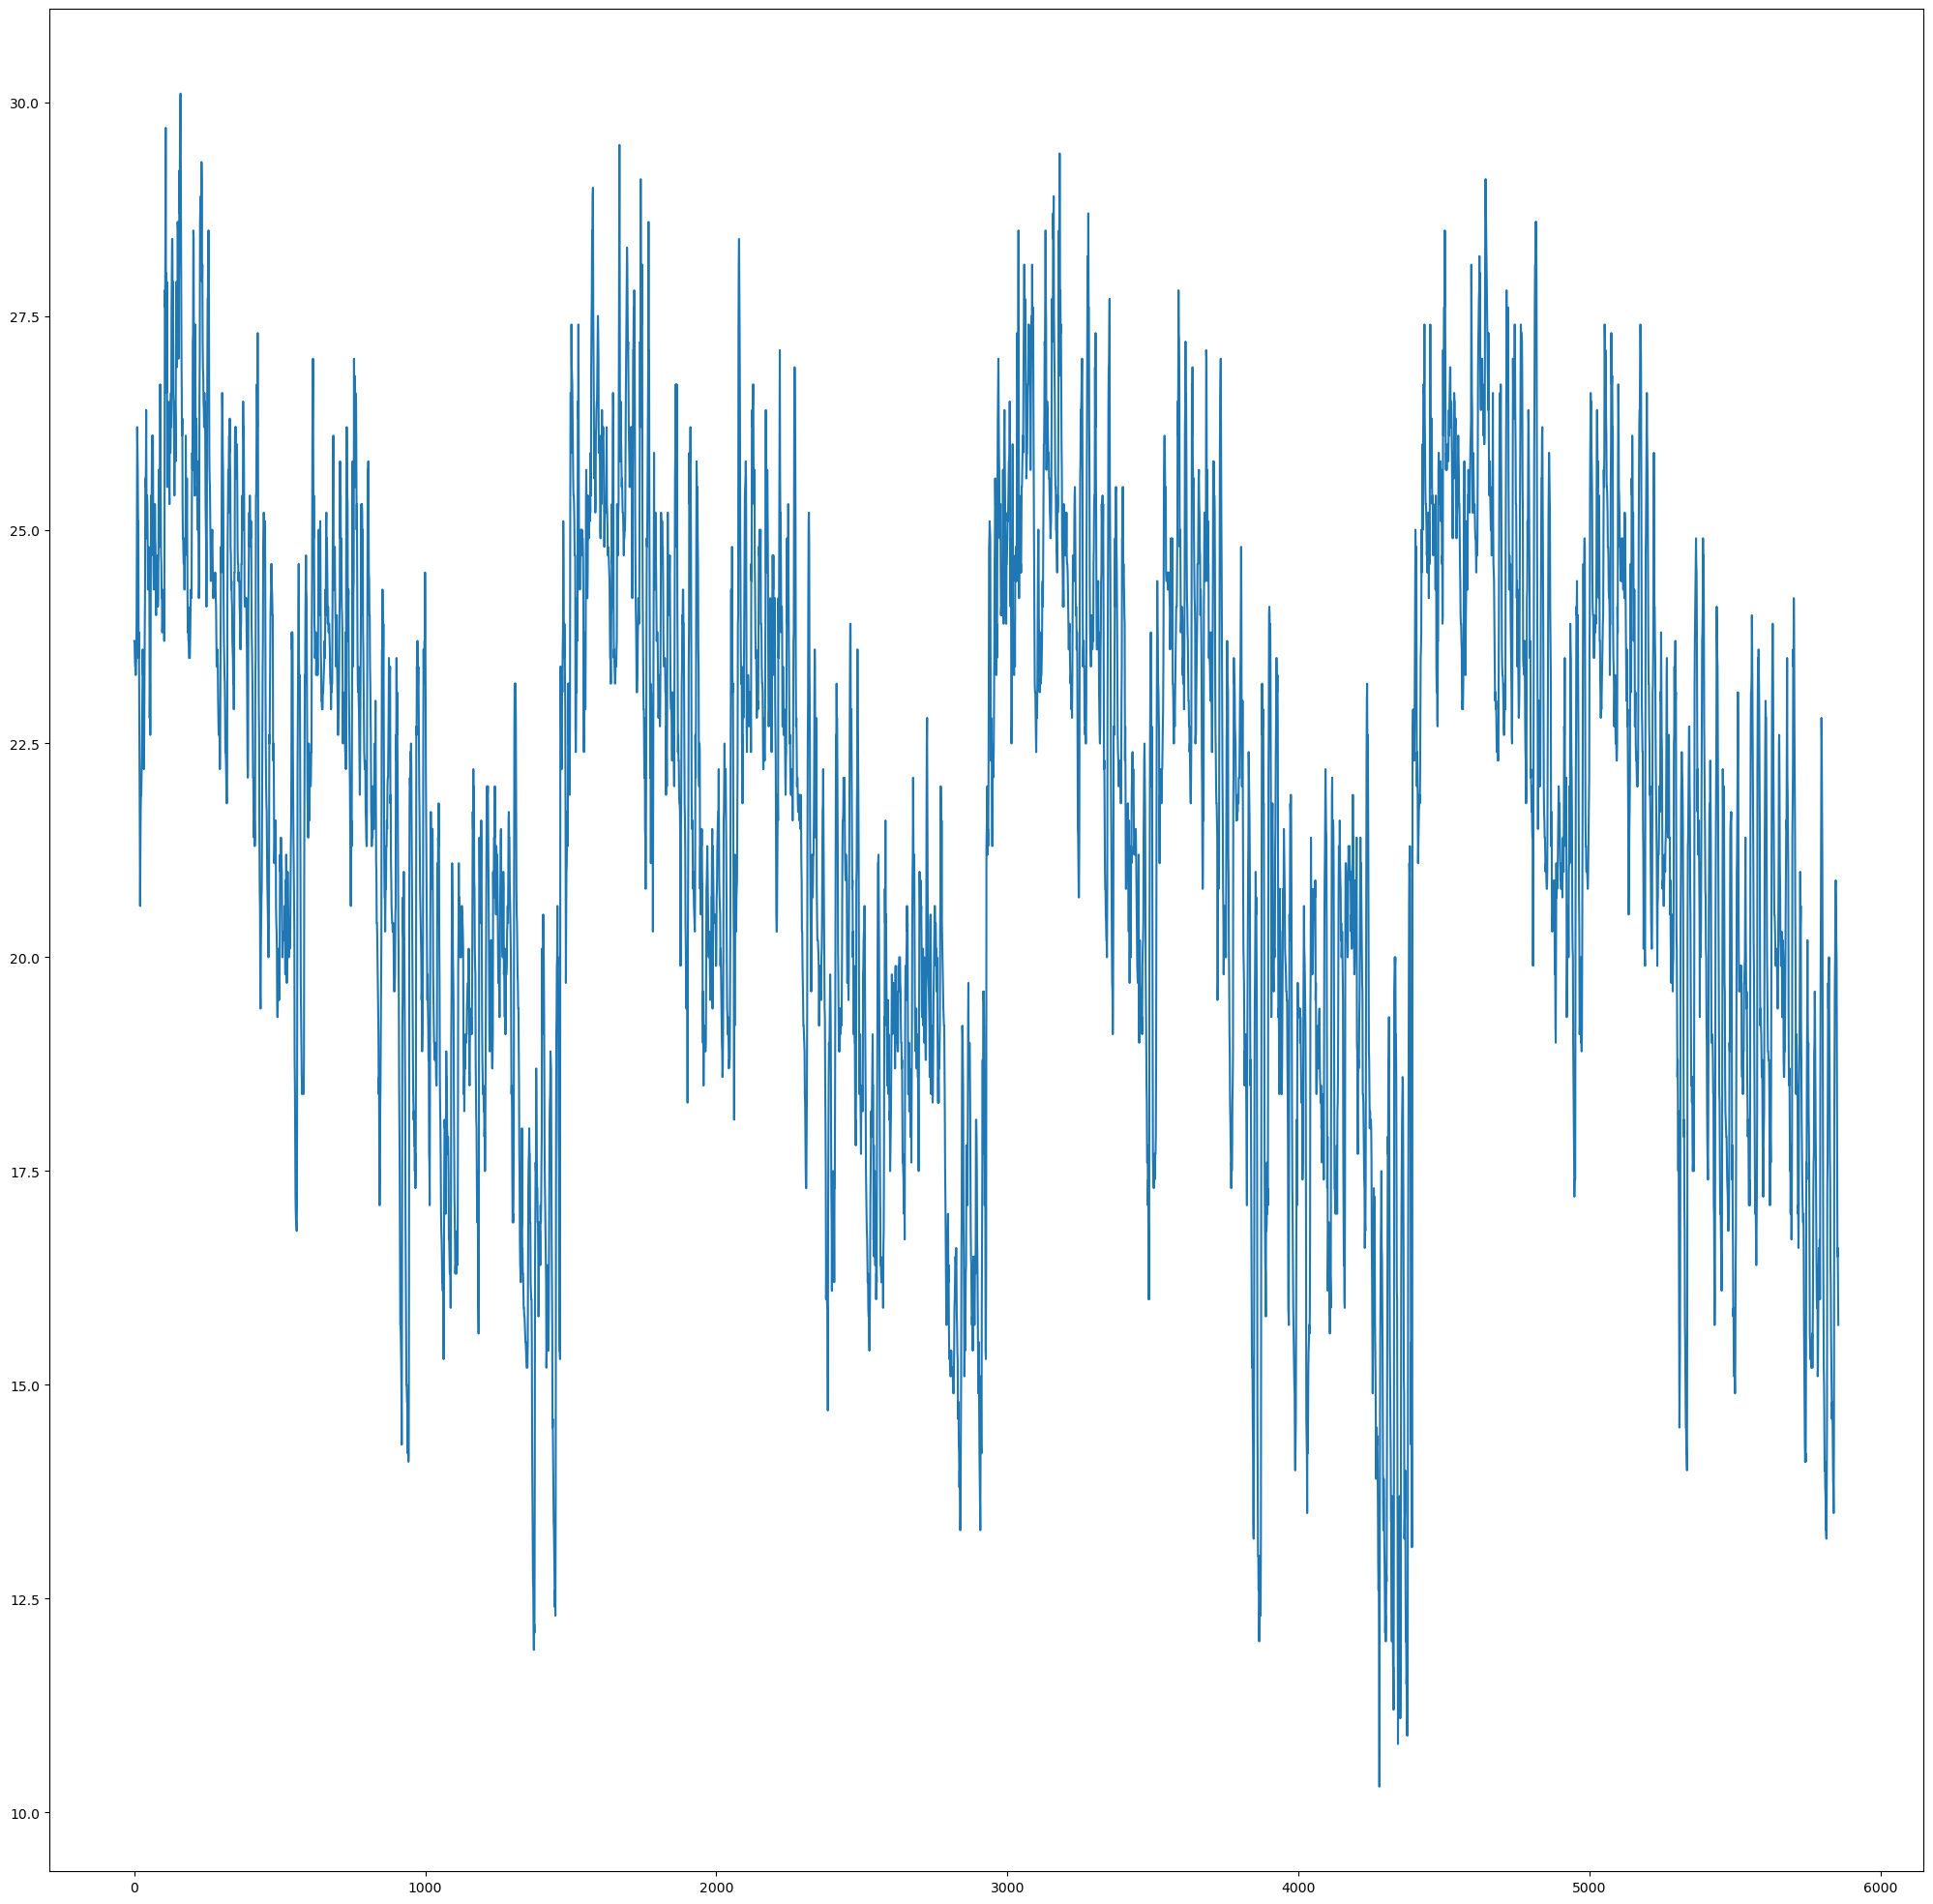

In [24]:
plt.figure(figsize=(25, 25))
plt.plot( weather['기온(°C)'])

In [25]:
weather = weather[((5 <= weather['time']) & (weather['time'] <= 13)) | ((17 <= weather['time']) & (weather['time'] <= 19))]
weather.reset_index(drop=True, inplace=True)
weather

,date,time,지점명,기온(°C),강수량(mm),풍속(m/s)
0,2019-09-01,5,제주,23.3,0.0,1.2
1,2019-09-01,6,제주,23.4,0.0,1.2
2,2019-09-01,7,제주,23.5,0.0,0.9
3,2019-09-01,8,제주,24.0,0.0,0.7
4,2019-09-01,9,제주,24.9,0.0,1.3
...,...,...,...,...,...,...
2923,2019-10-31,12,서귀포,20.0,0.0,1.8
2924,2019-10-31,13,서귀포,20.8,0.0,1.6
2925,2019-10-31,17,서귀포,20.0,0.0,0.7
2926,2019-10-31,18,서귀포,18.7,0.0,1.3


In [26]:
# 날짜별 풍속 및 강수량 저장용 df생성
new_weather = pd.DataFrame(data=weather[['date', '지점명']])
new_weather.drop_duplicates(inplace=True, ignore_index=True)

new_weather

,date,지점명
0,2019-09-01,제주
1,2019-09-02,제주
2,2019-09-03,제주
3,2019-09-04,제주
4,2019-09-05,제주
...,...,...
239,2019-10-27,서귀포
240,2019-10-28,서귀포
241,2019-10-29,서귀포
242,2019-10-30,서귀포


In [27]:
# join을 위한 키 생성
new_weather['date'] = pd.to_datetime(new_weather['date'])

new_weather['month'] = new_weather['date'].dt.month
new_weather['day'] = new_weather['date'].dt.day

In [28]:
new_weather

,date,지점명,month,day
0,2019-09-01,제주,9,1
1,2019-09-02,제주,9,2
2,2019-09-03,제주,9,3
3,2019-09-04,제주,9,4
4,2019-09-05,제주,9,5
...,...,...,...,...
239,2019-10-27,서귀포,10,27
240,2019-10-28,서귀포,10,28
241,2019-10-29,서귀포,10,29
242,2019-10-30,서귀포,10,30


In [29]:
# 시간 구간별 합을 저장하기 위한 행 생성
new_weather['5_8_rain'] = 0
new_weather['8_10_rain'] = 0
new_weather['10_12_rain'] = 0
new_weather['17_20_rain'] = 0

new_weather['5_8_wind'] = 0
new_weather['8_10_wind'] = 0
new_weather['10_12_wind'] = 0
new_weather['17_20_wind'] = 0

new_weather['5_8_temp'] = 0
new_weather['8_10_temp'] = 0
new_weather['10_12_temp'] = 0
new_weather['17_20_temp'] = 0

In [30]:
new_weather

,date,지점명,month,day,5_8_rain,8_10_rain,10_12_rain,17_20_rain,5_8_wind,8_10_wind,10_12_wind,17_20_wind,5_8_temp,8_10_temp,10_12_temp,17_20_temp
0,2019-09-01,제주,9,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-09-02,제주,9,2,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-09-03,제주,9,3,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-09-04,제주,9,4,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-09-05,제주,9,5,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2019-10-27,서귀포,10,27,0,0,0,0,0,0,0,0,0,0,0,0
240,2019-10-28,서귀포,10,28,0,0,0,0,0,0,0,0,0,0,0,0
241,2019-10-29,서귀포,10,29,0,0,0,0,0,0,0,0,0,0,0,0
242,2019-10-30,서귀포,10,30,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
# groupby사용
grouped = weather.groupby('time')

for group_key, group in grouped:
    group.reset_index(drop=True, inplace=True)
    if group_key <= 7:
        new_weather['5_8_rain'] += group['강수량(mm)'] / 3
        new_weather['5_8_wind'] += group['풍속(m/s)'] / 3
        new_weather['5_8_temp'] += group['기온(°C)'] / 3
    elif group_key <= 9:
        new_weather['8_10_rain'] += group['강수량(mm)'] / 2
        new_weather['8_10_wind'] += group['풍속(m/s)'] / 2
        new_weather['8_10_temp'] += group['기온(°C)'] / 2
    elif group_key <= 11:
        new_weather['10_12_rain'] += group['강수량(mm)'] / 2
        new_weather['10_12_wind'] += group['풍속(m/s)'] / 2
        new_weather['10_12_temp'] += group['기온(°C)'] / 2
    elif 17 <= group_key and group_key <= 19:
        new_weather['17_20_rain'] += group['강수량(mm)'] / 3
        new_weather['17_20_wind'] += group['풍속(m/s)'] / 3
        new_weather['17_20_temp'] += group['기온(°C)'] / 3

In [32]:
new_weather

,date,지점명,month,day,5_8_rain,8_10_rain,10_12_rain,17_20_rain,5_8_wind,8_10_wind,10_12_wind,17_20_wind,5_8_temp,8_10_temp,10_12_temp,17_20_temp
0,2019-09-01,제주,9,1,0.000000,0.00,0.00,3.733333,1.100000,1.00,2.25,2.366667,23.400000,24.45,26.05,22.366667
1,2019-09-02,제주,9,2,0.633333,10.15,0.75,0.000000,3.466667,4.65,1.30,1.800000,23.400000,22.25,22.85,25.566667
2,2019-09-03,제주,9,3,3.166667,1.30,0.15,0.333333,2.533333,0.95,1.85,2.666667,22.866667,24.15,25.05,24.666667
3,2019-09-04,제주,9,4,0.000000,16.70,0.75,0.000000,1.133333,1.35,2.20,1.433333,24.266667,24.40,24.45,26.033333
4,2019-09-05,제주,9,5,0.033333,0.00,0.00,0.733333,1.533333,1.05,0.80,2.466667,24.033333,26.45,28.00,25.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2019-10-27,서귀포,10,27,0.000000,0.00,0.00,0.000000,1.566667,0.90,1.95,0.766667,14.133333,16.50,18.05,17.833333
240,2019-10-28,서귀포,10,28,0.000000,0.00,0.00,0.000000,0.766667,1.00,1.05,1.100000,15.466667,16.70,17.65,17.500000
241,2019-10-29,서귀포,10,29,0.000000,0.00,0.00,0.000000,0.800000,1.00,1.55,2.033333,16.366667,17.20,20.10,18.033333
242,2019-10-30,서귀포,10,30,0.000000,0.00,0.00,0.000000,1.333333,1.10,1.45,1.333333,13.400000,15.90,18.20,17.933333


In [33]:
# 지점명에 대한 코드 부여
# 제주 0, 고산 1, 성산 2, 서귀포 3
new_weather['지점'] = np.nan

new_weather.loc[new_weather['지점명'] == '제주', '지점'] = 0
new_weather.loc[new_weather['지점명'] == '고산', '지점'] = 1
new_weather.loc[new_weather['지점명'] == '성산', '지점'] = 2
new_weather.loc[new_weather['지점명'] == '서귀포', '지점'] = 3

In [34]:
new_weather.drop(['date', '지점명'], axis=1, inplace=True)
new_weather

,month,day,5_8_rain,8_10_rain,10_12_rain,17_20_rain,5_8_wind,8_10_wind,10_12_wind,17_20_wind,5_8_temp,8_10_temp,10_12_temp,17_20_temp,지점
0,9,1,0.000000,0.00,0.00,3.733333,1.100000,1.00,2.25,2.366667,23.400000,24.45,26.05,22.366667,0.0
1,9,2,0.633333,10.15,0.75,0.000000,3.466667,4.65,1.30,1.800000,23.400000,22.25,22.85,25.566667,0.0
2,9,3,3.166667,1.30,0.15,0.333333,2.533333,0.95,1.85,2.666667,22.866667,24.15,25.05,24.666667,0.0
3,9,4,0.000000,16.70,0.75,0.000000,1.133333,1.35,2.20,1.433333,24.266667,24.40,24.45,26.033333,0.0
4,9,5,0.033333,0.00,0.00,0.733333,1.533333,1.05,0.80,2.466667,24.033333,26.45,28.00,25.833333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,10,27,0.000000,0.00,0.00,0.000000,1.566667,0.90,1.95,0.766667,14.133333,16.50,18.05,17.833333,3.0
240,10,28,0.000000,0.00,0.00,0.000000,0.766667,1.00,1.05,1.100000,15.466667,16.70,17.65,17.500000,3.0
241,10,29,0.000000,0.00,0.00,0.000000,0.800000,1.00,1.55,2.033333,16.366667,17.20,20.10,18.033333,3.0
242,10,30,0.000000,0.00,0.00,0.000000,1.333333,1.10,1.45,1.333333,13.400000,15.90,18.20,17.933333,3.0


In [35]:
new_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   month       244 non-null    int64  
 1   day         244 non-null    int64  
 2   5_8_rain    244 non-null    float64
 3   8_10_rain   244 non-null    float64
 4   10_12_rain  244 non-null    float64
 5   17_20_rain  244 non-null    float64
 6   5_8_wind    244 non-null    float64
 7   8_10_wind   244 non-null    float64
 8   10_12_wind  244 non-null    float64
 9   17_20_wind  244 non-null    float64
 10  5_8_temp    244 non-null    float64
 11  8_10_temp   244 non-null    float64
 12  10_12_temp  244 non-null    float64
 13  17_20_temp  244 non-null    float64
 14  지점          244 non-null    float64
dtypes: float64(13), int64(2)
memory usage: 28.7 KB


In [36]:
# df_train에 조인

df_train = df_train.merge(new_weather, left_on=['month', 'day', '지점명'], right_on=['month', 'day', '지점'], how='left')
df_train

,id,date,bus_route_id,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,...,17_20_rain,5_8_wind,8_10_wind,10_12_wind,17_20_wind,5_8_temp,8_10_temp,10_12_temp,17_20_temp,지점
0,0,2019-09-01,4270000,1,344,33.48990,126.49373,0.0,1.0,2.0,...,3.733333,1.100000,1.00,2.25,2.366667,23.400000,24.45,26.05,22.366667,0.0
1,1,2019-09-01,4270000,1,357,33.48944,126.48508,1.0,4.0,4.0,...,3.733333,1.100000,1.00,2.25,2.366667,23.400000,24.45,26.05,22.366667,0.0
2,2,2019-09-01,4270000,1,432,33.48181,126.47352,1.0,1.0,0.0,...,3.733333,1.100000,1.00,2.25,2.366667,23.400000,24.45,26.05,22.366667,0.0
3,3,2019-09-01,4270000,0,1579,33.50577,126.49252,0.0,17.0,6.0,...,3.733333,1.100000,1.00,2.25,2.366667,23.400000,24.45,26.05,22.366667,0.0
4,4,2019-09-01,4270000,0,1646,33.25579,126.41260,0.0,0.0,0.0,...,1.933333,1.266667,1.35,1.25,2.200000,22.500000,24.00,24.85,21.633333,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,33.41437,126.26336,4.0,0.0,0.0,...,11.100000,3.400000,3.40,2.00,2.733333,22.400000,23.75,25.45,23.833333,1.0
415419,415419,2019-09-30,32820000,0,1564,33.49946,126.51479,4.0,0.0,0.0,...,1.666667,0.433333,0.95,2.00,1.066667,22.866667,23.70,25.00,23.966667,0.0
415420,415420,2019-09-30,32820000,0,2322,33.23100,126.26273,0.0,0.0,0.0,...,11.100000,3.400000,3.40,2.00,2.733333,22.400000,23.75,25.45,23.833333,1.0
415421,415421,2019-09-30,32820000,0,3291,33.46483,126.31870,1.0,0.0,0.0,...,1.666667,0.433333,0.95,2.00,1.066667,22.866667,23.70,25.00,23.966667,0.0


In [37]:
df_train.head(3).T

,0,1,2
id,0,1,2
date,2019-09-01 00:00:00,2019-09-01 00:00:00,2019-09-01 00:00:00
bus_route_id,4270000,4270000,4270000
in_out,1,1,1
station_code,344,357,432
latitude,33.4899,33.48944,33.48181
longitude,126.49373,126.48508,126.47352
6~7_ride,0.0,1.0,1.0
7~8_ride,1.0,4.0,1.0
8~9_ride,2.0,4.0,0.0


In [38]:
df_train.corr()['18~20_ride'].sort_values(ascending=False)

18~20_ride       1.000000
11~12_ride       0.569747
10~11_ride       0.512666
9~10_ride        0.494085
8~9_ride         0.445316
7~8_ride         0.371751
11~12_takeoff    0.313540
9~10_takeoff     0.295875
10~11_takeoff    0.290691
8~9_takeoff      0.274360
6~7_ride         0.262173
7~8_takeoff      0.219430
6~7_takeoff      0.178353
latitude         0.079261
station_code     0.034360
in_out           0.022116
17_20_temp       0.019483
8_10_rain        0.011643
day              0.004882
5_8_rain         0.000119
id              -0.000544
10_12_temp      -0.002185
8_10_temp       -0.013221
5_8_temp        -0.016106
10_12_wind      -0.016743
10_12_rain      -0.019538
longitude       -0.021368
8_10_wind       -0.024767
17_20_wind      -0.032997
5_8_wind        -0.034264
17_20_rain      -0.038107
지점명             -0.087079
지점              -0.087079
bus_route_id    -0.143702
year                  NaN
month                 NaN
Name: 18~20_ride, dtype: float64

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 37 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             415423 non-null  int64         
 1   date           415423 non-null  datetime64[ns]
 2   bus_route_id   415423 non-null  int64         
 3   in_out         415423 non-null  int64         
 4   station_code   415423 non-null  int64         
 5   latitude       415423 non-null  float64       
 6   longitude      415423 non-null  float64       
 7   6~7_ride       415423 non-null  float64       
 8   7~8_ride       415423 non-null  float64       
 9   8~9_ride       415423 non-null  float64       
 10  9~10_ride      415423 non-null  float64       
 11  10~11_ride     415423 non-null  float64       
 12  11~12_ride     415423 non-null  float64       
 13  6~7_takeoff    415423 non-null  float64       
 14  7~8_takeoff    415423 non-null  float64       
 15  

In [40]:
df_train.drop('지점명', axis=1, inplace=True)
df_train.drop('지점', axis=1, inplace=True)

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 35 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             415423 non-null  int64         
 1   date           415423 non-null  datetime64[ns]
 2   bus_route_id   415423 non-null  int64         
 3   in_out         415423 non-null  int64         
 4   station_code   415423 non-null  int64         
 5   latitude       415423 non-null  float64       
 6   longitude      415423 non-null  float64       
 7   6~7_ride       415423 non-null  float64       
 8   7~8_ride       415423 non-null  float64       
 9   8~9_ride       415423 non-null  float64       
 10  9~10_ride      415423 non-null  float64       
 11  10~11_ride     415423 non-null  float64       
 12  11~12_ride     415423 non-null  float64       
 13  6~7_takeoff    415423 non-null  float64       
 14  7~8_takeoff    415423 non-null  float64       
 15  

## 날씨버전 모델 분석

In [42]:
df_train.drop('date', axis=1, inplace=True)

In [43]:
X = df_train.drop('18~20_ride', axis=1)
y = df_train['18~20_ride']

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [44]:
# 선형회귀
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model on the training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate the model on the validation data
lin_scores = cross_val_score(lr_model, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
lin_rmse = np.sqrt(-lin_scores.mean())
lin_rmse

3.5582016640028256

In [45]:
# 디시전 트리
# DecisionTree 교차검증
tree_reg = DecisionTreeRegressor(random_state=42)
tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
tree_rmse = np.sqrt(-tree_scores.mean())
tree_rmse

4.400517888409371

In [48]:
# 랜덤포레스트
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_reg = RandomForestRegressor(random_state=42)
rf_scores = cross_val_score(rf_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
rf_rmse = np.sqrt(-rf_scores.mean())
rf_rmse

3.0748591739995685

In [47]:
# 그레디언트 부스팅
from sklearn.ensemble import GradientBoostingRegressor
gbrt_reg = GradientBoostingRegressor(random_state=42)
gbrt_scores = cross_val_score(gbrt_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
gbrt_rmse = np.sqrt(-gbrt_scores.mean())
gbrt_rmse

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
#svm 정규화 기다리고 있겠읍니다. 동심님
